In [15]:
import json
import pathlib
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from net import UnetGenerator
from argparse import Namespace
from torchvision import datasets
from utils import ABImageDataset, ToTensorTwoIMG, Normalize, ComposeTwoIMG, SplitImage
import cv2

In [11]:
number=2
seed=1
data_name='edges2shoes'

In [12]:
result_path = pathlib.Path('/Users/yohei/MyDrive/tlab/pix2pix.pytorch/{0}/'
                           'result_{1}/result_{1}_{2}'.format(
                               data_name, number, seed))
data_path = pathlib.Path(
    '/Users/yohei/MyDrive/tlab/pix2pix.pytorch/{0}/'.format(data_name))
model_path = result_path / 'model'
log_path = result_path / 'log.json'
arg_path = result_path / 'args.txt'
train_data_path = data_path / 'train_data'
val_data_path = data_path / 'validation_data'

In [13]:
log = json.load(open(log_path))

# ロスの推移

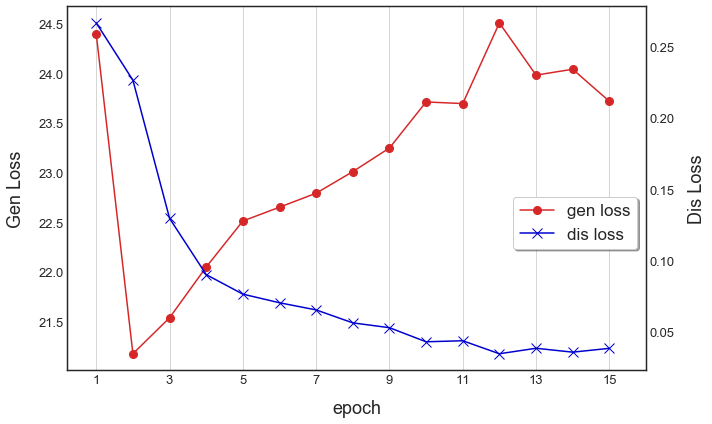

In [21]:
#from matplotlib import rc
# Tex font
#rc('text', usetex=False)
dis_loss = [log[key]['train_dis_loss'] for key in log.keys()]
gen_loss = [log[key]['train_gen_loss'] for key in log.keys()]
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
line_1 = ax.plot(gen_loss, label='gen loss', c="tab:red", marker='o',ms=8)
ax.grid(axis="x")
ax.set_xlim([-0.8, 15])
ax2 = ax.twinx()
line_2 = ax2.plot(
    dis_loss, label='dis loss', c="mediumblue", marker='x', ms=10)
fig.legend(
    loc='upper right',
    bbox_to_anchor=(1, 0.5),
    bbox_transform=ax.transAxes,
    frameon=True,
    shadow=True,
    fontsize=17)
ax.tick_params(labelsize=13)
ax2.tick_params(labelsize=13)
ax.set_xticklabels([2 * i + 1 for i in range(-1, 8)])
ax.set_xlabel("epoch", fontsize=18, labelpad=13)
ax.set_ylabel("Gen Loss", fontsize=18, labelpad=13)
ax2.set_ylabel("Dis Loss", fontsize=18, labelpad=13)

plt.tight_layout()
fig.savefig(
    result_path / "loss_{}_{}.png".format(number, seed),
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1)

# 生成データの可視化

In [115]:
with open(arg_path) as f:
    opt = eval(f.read())
print(opt)

Namespace(batch_size=4, epoch=15, gpu=0, lambda_L1=100.0, mean=0.5, ndf=64, ngf=64, norm_type='batch', num_workers=4, number=2, seed=1, std=0.5, val_size=0.15, version=False)


In [116]:
# load Generator
checkpoint=torch.load(model_path / 'pix2pix_14epoch.tar', map_location="cpu")
gen = UnetGenerator(norm_type=opt.norm_type, ngf=opt.ngf)
gen.load_state_dict(checkpoint['gen_model_state_dict'])

In [117]:
# load dataset
transform = {
    'train': ComposeTwoIMG([ToTensorTwoIMG()]),
    'val': ComposeTwoIMG([ToTensorTwoIMG()])
}
mean = [opt.mean, opt.mean, opt.mean]
std = [opt.std, opt.std, opt.std]

datasets = {
    'train':
    ABImageDataset(
        root=train_data_path,
        transform=transform['train'],
        normalizer=Normalize(mean, std),
        spliter=SplitImage(right_is_A=False)),
    'val':
    ABImageDataset(
        root=val_data_path,
        transform=transform['val'],
        val_size=opt.val_size,
        normalizer=Normalize(mean, std),
        spliter=SplitImage(right_is_A=False))
}

data_loader = {
    phase: DataLoader(
        datasets[phase],
        batch_size=len(datasets[phase]),
        shuffle=False,
        num_workers=0)
    for phase in ['train', 'val']
}

data_loader

{'train': <torch.utils.data.dataloader.DataLoader at 0x163899588>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1638997b8>}

In [118]:
"""
fig, ax = plt.subplots(16, 2, figsize=(10, 60))
datas = next(iter(data_loader['train']))
for i in range(len(datasets['train'])):
    ax[i, 0].imshow(
        cv2.cvtColor((datas[0][i]*0.5 + 0.5).numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB))
    ax[i, 1].imshow(
        cv2.cvtColor((datas[1][i]*0.5 + 0.5).numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB))
    # print(data[1].min(), data[1].max())
"""


"\nfig, ax = plt.subplots(16, 2, figsize=(10, 60))\ndatas = next(iter(data_loader['train']))\nfor i in range(len(datasets['train'])):\n    ax[i, 0].imshow(\n        cv2.cvtColor((datas[0][i]*0.5 + 0.5).numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB))\n    ax[i, 1].imshow(\n        cv2.cvtColor((datas[1][i]*0.5 + 0.5).numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB))\n    # print(data[1].min(), data[1].max())\n"

In [119]:
gen.train()

# visualize train datasets
with torch.no_grad():
    #fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    for inputs, _ in data_loader['train']:
        print(inputs.max(), inputs.min())
        fake_optputs = gen(inputs)
print(fake_optputs.max(), fake_optputs.min())
fake_optputs = fake_optputs * 0.5 + 0.5
gen_grid = make_grid(fake_optputs, 4, 4)
# axes.imshow(gen_grid.numpy().transpose(1, 2, 0))

tensor(1.) tensor(0.)
tensor(1.2873) tensor(-1.4479)


In [120]:
gen_grid.detach().numpy()

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [126]:
a = torch.randn((10, 3, 256, 256))
a = gen(a)

In [127]:
a.grad_fn

In [125]:
a = torch.randn((10, 3, 256, 256))
a = torch.nn.Tanh()(a)
a.min(), a.max()

(tensor(-0.9999), tensor(0.9999))